## IGO15488_1_2 combined
8/29/2024 - Data generated from Exercise-p53 mice KPT. From Klavdija, aligned by Jason with CellRanger-v6.1.1
Analyze global run on cellranger v6 data and create h5_ad files for further analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib
from matplotlib import pyplot as plt

from pathlib import Path
import anndata

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55916/2080842915.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
#plt.rcParams['figure.figsize'] = (3,4)

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [4]:
#Path("./figures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

Read in the count matrix into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5 file format: `.h5ad`.

In [5]:
adata1 = anndata.read('../IGO15488_1/write/allmice-tumor-KPT1.h5ad')
adata2 = anndata.read('../IGO15488_2/write/allmice-tumor-KPT2.h5ad')

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
adata = adata1.concatenate(adata2, join='inner', batch_categories=['lane1', 'lane2'])
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55916/2401071598.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata1.concatenate(adata2, join='inner', batch_categories=['lane1', 'lane2'])


## Now select only KP Rosa26-tdTomato/+ mice

In [7]:
adata.obs.Classification.value_counts(sort=False)

Classification
BB1053_B0314    770
BD1446_B0315    231
BD1959_B0303    858
BD1970_B0313    142
BD1971_B0313    298
BD1976_B0302    755
BE1864_B0311    214
BF1106_B0311    705
BF1443_B0301    379
BF1448_B0304    317
BF1449_B0305    752
BF1451_B0305    264
BF1556_B0302    261
BF1585_B0312      4
BF1588_B0312     77
BF1595_B0304    223
BF1596_B0301     60
BF1607_B0303    237
Name: count, dtype: int64

In [8]:
adata = adata[adata.obs.Classification.isin(['BF1607_B0303','BD1959_B0303','BB1053_B0314']),:]

## Look at lane and batch statistics

In [9]:
adata.obs.Classification.value_counts()

Classification
BD1959_B0303    858
BB1053_B0314    770
BF1607_B0303    237
Name: count, dtype: int64

In [10]:
adata.obs[['batch','Classification']].value_counts()

batch  Classification
lane2  BD1959_B0303      858
       BB1053_B0314      632
lane1  BF1607_B0303      237
       BB1053_B0314      138
Name: count, dtype: int64

## Set group

In [11]:
adata.obs['Group'] = 'KPT'

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55916/241905987.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Group'] = 'KPT'


## Set highly variable genes

In [12]:
sc.pp.highly_variable_genes(adata, batch_key='batch')

extracting highly variable genes


/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:508: FutureWarning: The provided callable <function nanmean at 0x109990d60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby("gene").agg(
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:508: FutureWarning: The provided callable <function nanmean at 0x109990d60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby("gene").agg(
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:508: FutureWarning: The provided callable <function nansum at 0x109990860> is current

In [13]:
adata.var.highly_variable = adata.var.highly_variable_intersection

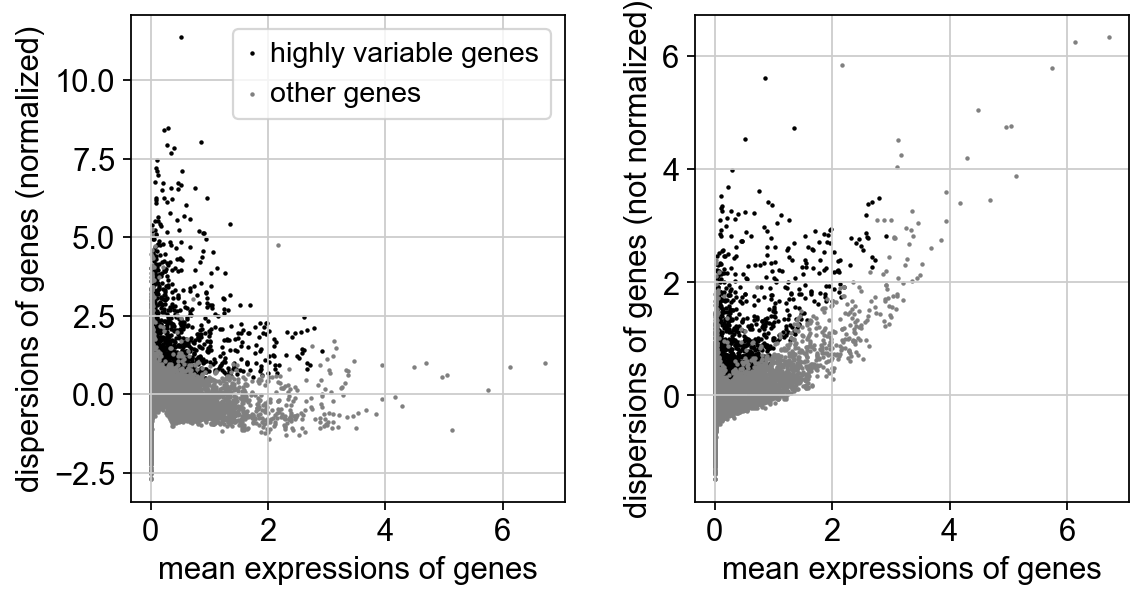

In [14]:
sc.pl.highly_variable_genes(adata)

In [15]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['tdTomato'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55916/3831354682.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['tdTomato'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55916/38

In [16]:
adata.write('write/allmice-IGO15488_combined.h5ad', compression='gzip')